In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

import numpy as np
import sys, pickle, os, torch, cv2, imageio
# replace this path with path to GMIC
#sys.path.append("/home/mimodem/Desktop/GMIC")

from src.data_loading import loading
from src.modeling import gmic as gmic

/home/mimodem/anaconda3/envs/GMIC/lib/python3.6/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#for n in range(0, 191, 1):
    n=14
    with open("sample_output/Gmic_1/nyu_gmic.pkl", "rb") as f:
        exam_list = pickle.load(f)
    datum = exam_list[n]
    view = "R-CC" # Elegir vista -------------------------------------------------------------------------
    short_file_path = datum[view][0]
    
    loaded_image2 = loading.load_image(
                        image_path=os.path.join("sample_output/Gmic_1/cropped_images/", short_file_path + ".png"),
                        view=view, horizontal_flip="NO")
    
    w1,w2 = datum["best_center"][view][0];
    loaded_image = loading.process_image(loaded_image2, view, (w1,w2))
    
    parameters = {
            "device_type":"cpu",
            "cam_size": (46, 30),
            "K": 6,
            "crop_shape": (256, 256),
            "percent_t":0.02
        }
    
    model = gmic.GMIC(parameters)
    model.load_state_dict(torch.load("models/sample_model_1.p", map_location="cpu"), strict=False)
    
    tensor_batch = torch.Tensor(np.expand_dims(np.expand_dims(loaded_image, 0), 0).copy()) # La imagen como tensor
    output = model(tensor_batch) # Prediccion de la imagen
    saliency_maps = model.saliency_map.data.cpu()
    heatmap = saliency_maps[0,1,:,:]
    heatmap2 = heatmap.numpy()
    heatmap2 = heatmap2/np.max(heatmap2)/0.820118
    heatmap2 = cv2.resize(heatmap2, (1920, 2944))
    # interpolate the heatmap
    img = cv2.imread("sample_output/Gmic_1/cropped_images/" + short_file_path + ".png")
    input_size=(2944, 1920)
    borders = loading.bordbord(loaded_image2, view, datum["best_center"][view][0])
    ########################################################
    if (view == "R-MLO")or(view == "R-CC"):
        img2 = cv2.flip(img, 1)   
    else:
        img2 = img
    ########################################################
    cropped_image = img2[borders[0]: borders[1], borders[2]: borders[3]]
    ########################################################
    if (np.shape(loaded_image) != np.shape(cropped_image[:,:,1])):#ok
        if (view == "L-MLO") or (view == "R-MLO"):#ok
            newc = np.zeros((np.shape(loaded_image)[0],np.shape(loaded_image)[1],3),np.uint8)#ok
            newc[0:np.shape(cropped_image)[0],0:np.shape(cropped_image)[1],:] = cropped_image#ok
            heatheat = heatmap2[0:np.shape(cropped_image)[0],0:np.shape(cropped_image)[1]]#ok
        else:
            newc = np.zeros((np.shape(loaded_image)[0],np.shape(loaded_image)[1],3),np.uint8)#ok
            A = int((np.shape(loaded_image)[0]-np.shape(cropped_image)[0])/2)#ok
            newc[A:A+np.shape(cropped_image)[0],0:np.shape(cropped_image)[1],:] = cropped_image#ok
            heatheat = heatmap2[A:A+np.shape(cropped_image)[0],0:np.shape(cropped_image)[1]]#ok
    else:
        newc = cropped_image
        heatheat = heatmap2
    ########################################################    
    heatheat2 = np.zeros((np.shape(img)[0],np.shape(img)[1]))#ok
    heatheat2[borders[0]: borders[1], borders[2]: borders[3]] = heatheat#ok    
    ########################################################
    if (view == "R-MLO")or(view == "R-CC"):
        heatheat3 = cv2.flip(heatheat2, 1)   
    else:
        heatheat3 = heatheat2
    imht = np.uint8(255*heatheat3)
    imht = cv2.applyColorMap(imht, cv2.COLORMAP_JET)
    superimposed_img = imht* 0.4 + img*0.6# OriginalCropped
    # cv2.imwrite('sample_output/ColorHeatmaps/' + short_file_path + '_CAM1_EXAMPLE.jpg', superimposed_img)

/home/mimodem/Desktop/GMIC/src/utilities/tools.py:198: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_idx_x = max_linear_idx // W_map


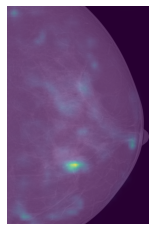

In [3]:
plt.imshow(loaded_image, cmap='gray')
plt.imshow(heatmap2, alpha=0.6)
plt.axis("off")
plt.show()

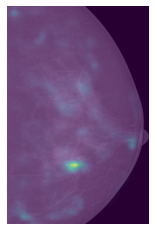

In [4]:
plt.imshow(newc)
plt.imshow(heatmap2, alpha=0.6)
plt.axis("off")
plt.show()

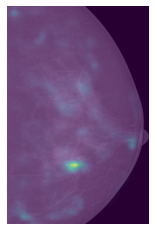

In [5]:
plt.imshow(cropped_image)
plt.imshow(heatheat, alpha=0.6)
plt.axis("off")
plt.show()

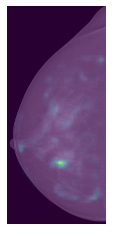

In [6]:
plt.imshow(img)
plt.imshow(heatheat3, alpha=0.6)
plt.axis("off")
plt.show()